In [59]:
import numpy as np
import sys 
sys.path.append(r'../../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [60]:
#Saving Directory
rootdir = "../../Cart Pendulum/"

num_sample = 1
create_data = False
training = False

a = 1
b = 1
noiselevel = a*10**(-b)

In [61]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [62]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [63]:
# identifier = "no"
identifier = str(a) + "e-0" + str(b)
if(training==False):
    with open(rootdir + "Data/Active/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)

0.11*x0_t**2 + 0.24*x0_t*x1_t*cos(x0) + 0.36*x1_t**2 + 2.03*cos(x0)


In [64]:
#for lagrangian
x0 = dynamicsymbols(states[0], real=True)
x1 = dynamicsymbols(states[1], real=True)
x0_t = dynamicsymbols(states[0],1, real=True)
x1_t = dynamicsymbols(states[1],1, real=True)
F = symbols('F')

#True Lagrangian
L = 0.11*x0_t**2 + 0.24*x0_t*x1_t*cos(x0) + 0.36*x1_t**2 + 2.03*cos(x0)

# Lagrange's method
LM = LagrangesMethod(L, [x0,x1])
LM.form_lagranges_equations()
i_forcing = LM.forcing #internal forcing and gravity
e_forcing = sympy.Matrix([0, F]) #external generalized force

In [65]:
# Substituting dynamic symbols

i_forcing = i_forcing.subs(x0_t, states_sym[2])
i_forcing = i_forcing.subs(x1_t, states_sym[3])
i_forcing = i_forcing.subs(x0, states_sym[0])
i_forcing = i_forcing.subs(x1, states_sym[1])

M = LM.mass_matrix
M = M.subs(x0, states_sym[0])
M = M.subs(x1, states_sym[1])

In [66]:
# Generating equation of motion
t_forcing = i_forcing + e_forcing
eom = M.inv()*sympy.Matrix(t_forcing)

In [67]:
''' Please copy the string shown to the definition of equation in the function of double pendulum'''
for i in range(len(eom)):
    print('Equation ' + str(i) +': ' + str(eom[i]))
    print('\n')

Equation 0: 0.0528*(F + 0.24*x0_t**2*sin(x0))*cos(x0)/(0.012672*cos(x0)**2 - 0.034848) - 0.321552*sin(x0)/(0.034848 - 0.012672*cos(x0)**2)


Equation 1: -0.4872*sin(x0)*cos(x0)/(0.0576*cos(x0)**2 - 0.1584) + 0.22*(F + 0.24*x0_t**2*sin(x0))/(0.1584 - 0.0576*cos(x0)**2)




In [68]:
import time

g=9.81
mp=0.5

mc=1
L=1

def torque(t,omega):
    return 0*np.cos(omega*t), 1*np.cos(omega*t)


def predictedcartpole(t,y,omega):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    _, F = torque(t, omega)
    x0_tt = eval(str(eom[0]))
    x1_tt = eval(str(eom[1]))
    return x0_t,x1_t,x0_tt,x1_tt

def cartpole(t,y,omega):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    _, F = torque(t, omega)
    x0_tt = -(1.0*g*(mc + mp)*sin(x0) + 1.0*(F + L*mp*x0_t**2*sin(x0))*cos(x0))/(L*(mc + mp*sin(x0)**2))
    x1_tt =  1.0*(F + L*mp*x0_t**2*sin(x0) + g*mp*sin(x0)*cos(x0))/(mc + mp*sin(x0)**2)
    return x0_t,x1_t,x0_tt,x1_tt


def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='LSODA', rtol=1e-10,atol=1e-10, args=[omega])
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:], omega = omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)

In [69]:
## SINDy-PI ##

'''file name : Double Pendulum/Data/SINDy-PI_2e-02_noise.txt'''

def SINDyPI(t,y):
    from numpy import sin, cos
    z1,z2,z3,z4 = y
    dz1=1.0*z3
    dz2=z4
    dz3=(2.292e+7*sin(2.0*z1 - 2.0*z2) - 2.093e+7*sin(2.0*z1 - 1.0*z2) + 2.005e+7*sin(z1 - z2) + 1.238e+7*sin(z1 - 2.0*z2) + 7.062e+7*sin(z1) - 5.678e+6*sin(z2) + 1.477e+6*z3**2*sin(2.0*z1 - 1.0*z2) + 1.06e+6*z4**2*sin(2.0*z1 - 1.0*z2) - 1.609e+6*z4**2*sin(2.0*z1 - 2.0*z2) - 1.887e+6*z3**2*sin(z1 - z2) + 3.678e+6*z4**2*sin(z1 - z2) + 1.541e+6*z3**2*sin(z1 - 2.0*z2) + 9.951e+5*z4**2*sin(z1 - 2.0*z2))/(6.543e+6*cos(z1 - 1.0*z2)**2 - 1.0e+7)
    dz4=-(1.0*(8.16*sin(2.0*z1 - 1.0*z2) + 3.179*sin(2.0*z1 - 2.0*z2) - 2.906*sin(z1 - z2) + 1.408*sin(z1) - 9.208*sin(z2) + 0.8598*z3**2*sin(z1 - z2)))/(cos(z1 - 1.0*z2)**2 - 1.307)
    return dz1, dz2, dz3, dz4

In [70]:
## Training Results ##
import matplotlib.pyplot as plt

t = np.arange(0,10,0.01)
theta = 1.3840787544946762
thetadot = np.random.uniform(0,0)
omega = 1.9613685766006796

_, F = torque(t, omega)
tau = np.array([_, F]).T    
y0=np.array([theta, 0, thetadot, 0])

#true value
X,Xdot = generate_data(cartpole,t,y0,omega=omega)



q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
noise[500:] = 0
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#xL-SINDy (active)
Xpred, Xdotpred = generate_data(predictedcartpole, t, y0, omega=omega) 

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T

# #SINDy PI
# Xspi, Xdotspi = generate_data(SINDyPI, t, y_0) 

# q_tt_spi = Xdotspi[:,states_dim//2:].T
# q_t_spi = Xdotspi[:,:states_dim//2].T
# q_spi = Xspi[:,:states_dim//2].T

In [71]:
## Test Results ##
# ttest = np.arange(5,10,0.01)
# y_0 = np.array([q_true_wn[0,-1], q_true_wn[1,-1], q_t_true_wn[0,-1], q_t_true_wn[1,-1]])
# Xtest,Xdottest = generate_data(doublePendulum, ttest, y_0)

# y_0 = np.array([q_pred[0,-1], q_pred[1,-1], q_t_pred[0,-1], q_t_pred[1,-1]])
# Xtestpred,Xdottestpred = generate_data(predicteddoublependulum, ttest, y_0)

# # y_0 = np.array([q_spi[0,-1], q_spi[1,-1], q_t_spi[0,-1], q_t_spi[1,-1]])
# # Xtestspi,Xdottestspi = generate_data(SINDyPI, ttest, y_0)

In [72]:
# Concatenante training and test data
# t = np.concatenate((t, ttest))
# q_tt_true = np.concatenate((q_tt_true, Xdottest[:,states_dim//2:].T), axis=1)
# q_t_true = np.concatenate((q_t_true, Xtest[:,states_dim//2:].T), axis=1)
# q_true = np.concatenate((q_true,Xtest[:,:states_dim//2].T), axis=1)

# q_tt_pred = np.concatenate((q_tt_pred,Xdottestpred[:,states_dim//2:].T), axis=1)
# q_t_pred = np.concatenate((q_t_pred, Xtestpred[:,states_dim//2:].T), axis=1)
# q_pred = np.concatenate((q_pred,Xtestpred[:,:states_dim//2].T), axis=1)

# q_tt_spi = np.concatenate((q_tt_spi,Xdottestspi[:,states_dim//2:].T), axis=1)
# q_t_spi = np.concatenate((q_t_spi, Xtestspi[:,states_dim//2:].T), axis=1)
# q_spi = np.concatenate((q_spi,Xtestspi[:,:states_dim//2].T), axis=1)

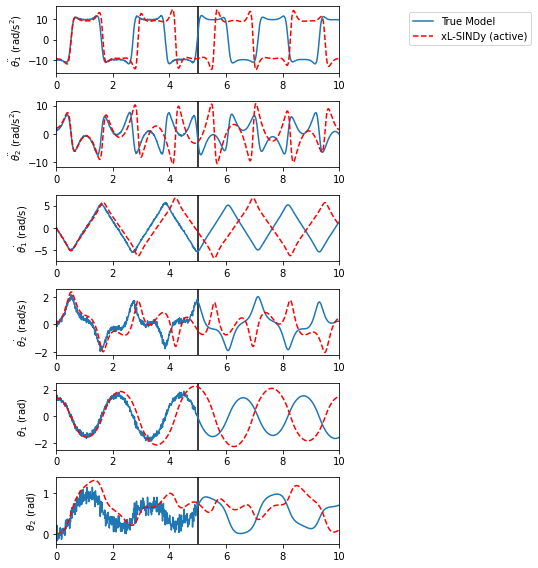

In [73]:
fig, ax = plt.subplots(6,1,figsize=(5,8))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[0].plot(t, q_tt_spi[0,:], ':g', label='SINDy-PI')
ax[0].set_ylabel('$\ddot{\\theta_1}$ (rad/s$^2$)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])

ax[1].plot(t, q_tt_true[1,:], label='True Model')
ax[1].plot(t, q_tt_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[1].plot(t, q_tt_spi[1,:], ':g',label='SINDy-PI')
ax[1].set_ylabel('$\ddot{\\theta_2}$ (rad/s$^2$)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])

ax[2].plot(t, q_t_true[0,:], label='True Model')
ax[2].plot(t, q_t_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[2].plot(t, q_t_spi[0,:], ':g',label='SINDy-PI')
ax[2].set_ylabel('$\dot{\\theta_1}$ (rad/s)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])

ax[3].plot(t, q_t_true[1,:], label='True Model')
ax[3].plot(t, q_t_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[3].plot(t, q_t_spi[1,:], ':g',label='SINDy-PI')
ax[3].set_ylabel('$\dot{\\theta_2}$ (rad/s)')
ax[3].vlines(5,0,1,transform=ax[3].get_xaxis_transform(),colors='k')
ax[3].set_xlim([0,10])

ax[4].plot(t, q_true[0,:], label='True Model')
ax[4].plot(t, q_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[4].plot(t, q_spi[0,:], ':g',label='SINDy-PI')
ax[4].set_ylabel('$\\theta_1$ (rad)')
ax[4].vlines(5,0,1,transform=ax[4].get_xaxis_transform(),colors='k')
ax[4].set_xlim([0,10])
#ax[4].set_ylim([-1.8,1.8])

ax[5].plot(t, q_true[1,:], label='True Model')
ax[5].plot(t, q_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[5].plot(t, q_spi[1,:], ':g',label='SINDy-PI')
ax[5].set_ylabel('$\\theta_2$ (rad)')
ax[5].vlines(5,0,1,transform=ax[5].get_xaxis_transform(),colors='k')
ax[5].set_xlim([0,10])
#ax[5].set_ylim([-4,4])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/Active/training_" + identifier + "_noise.png", bbox_inches='tight',dpi=400)


In [74]:
np.save(rootdir + "Data/Active/q_pred_" + identifier + "_noise.png", q_pred)
np.save(rootdir + "Data/Active/q_true", q_true)